In [98]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import os
import time
from sklearn.utils.class_weight import compute_class_weight
import shap
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import random
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.stats import multivariate_normal

In [99]:
def select_features(data, type_of, k):
    """
    select_features: Filter data using various feature importance methods.

    - 'corr': Filters based on correlation.
    - 'ft_importance': Filters using feature importance from Random Forest.
    - 'kbest': Filters using Select K-Best from scikit.

    Parameters:
        - type_of (string): The type of feature importance to measure correlation (corr), feature importance from Random Forest (ft_importance), and Select K-Best (k-best).

    Returns:
        top_k_features (list): The list of n features.
    """
    
    X = data.drop(columns=['attack_cat', 'Label'])
    y = data['Label']
    
    if type_of == 'correlation':
        corr_values = {}
        for feature in X.columns:
            corr_values[feature] = X[feature].corr(y)
        corr_data = pd.Series(corr_values).abs()
        top_k_features = corr_data.nlargest(k).index.tolist()
        return top_k_features

    elif type_of == 'ft_importance':
        model = RandomForestClassifier()
        model.fit(X, y)
        feature_importances = pd.Series(model.feature_importances_, index=X.columns)
        top_k_features = feature_importances.nlargest(k).index.tolist()
        return top_k_features

    elif type_of == 'kbest':
        selector = SelectKBest(score_func=f_classif, k=k)
        selector.fit(X, y)
        top_k_features = []
        selected_mask = selector.get_support()
        for i in range(len(selected_mask)):
            if selected_mask[i]:
                top_k_features.append(X.columns[i])

        return top_k_features
                

In [ ]:
class CorrEncoder:
    """
    CorrEncoder: Takes a dataset as input and uses it for the encode function. Encodes the filtered categories then draws correlations.
    If correlation is above the threshold adds it to a new dataframe then returns the one hot encoded values with the labels.

    Initialisation:
        - data (pd.DataFrame): The Dataset that contains the target column and target label variables.
    """
    
    def __init__(self, data):
        self.data = data.copy()
        # Removes Label for the multi-class processing as it is based on the label category (threat or not).
        self.data = self.data.drop(columns=['attack_cat'])

    def encode(self, target_column, sparse_n, threshold, print_data):
        """
        encode: Takes a target column and target label to encode and draw correlations from. The target column is iterated through
        for all categories that contain more positive values than defined in sparse_n. This allows for filtering of sparse categories.
        The function then one hot encodes the given category with the static target column and draws correlations for them. If correlation
        is greater then threshold then add it to the new DataFrame. The function returns the one hot encoded categories that pass the
        threshold with the target label.

        The purpose of this function is to resolve the high cardinality problem in one hot encoding.

        Parameters:
            - target_column (string): The name of the target column. The target column should contain the various categories to encode.
            - sparse_n (integer): The minimum amount of positive values required for a category after encoding (deals with sparse categories).
            - threshold (float): The threshold for correlation. The function creates onehot encoded columns of all variables that have correlation
              higher that the threshold to the target label.

        Returns:
            - ohe_df (pd.DataFrame): The one hot encoded values from the target column.
        """

        # Convert to string to handle duplicates.
        self.data[target_column] = self.data[target_column].astype(str)
        value_counts = self.data[target_column].value_counts()
        # Check if number of 1s is above the given threshold set by sparse_n.
        categories = value_counts[value_counts > sparse_n].index.tolist()
        ohe_list = []

        # Attack category (target label)
        attack_cat = self.data['Label']
        
        # Go through each unique category in the target column.
        for c in categories:
            col_name = f'{target_column}_{c}'

            # Create the binary encoding column for the current category and target label.
            corr_column = (self.data[target_column] == c).astype(int)
            correlation = corr_column.corr(attack_cat)

            # Check if absolute correlation is greater than threshold.
            if abs(correlation) > threshold:
                corr_column.name = col_name
                ohe_list.append(corr_column)
        if print_data:
            print('Number of Encoded Features for', target_column)
            print(len(ohe_list))
        if ohe_list:
            # NOTE: This section can be expanded to include print outs but at the moment am focusing on the evaluations.
            ohe_df = pd.concat(ohe_list, axis=1)
            return ohe_df
        else:
            return pd.DataFrame()

In [ ]:
import pandas as pd

def print_outliers(df, columns):
    """
    print_outliers: A basic print function for outliers. Returns the total of upper and lower outliers.

    Parameters:
    - df (pandas DataFrame): The DataFrame with the columns.
    - columns (list): The columns to check.

    """
    rows_to_remove = []
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        rows_to_remove.extend(outliers.index)
    outliers = list(set(rows_to_remove))
    print(f"Number of outlier Rows (Local Only): {len(outliers)}")

In [ ]:
class KmeansPlusPlus:
    """
    KmeansPlusPlus: Uses scikit Kmeans to try and create two distinct clusters and centroids using Kmeans++.

    Initialisation:
        - data (pd.DataFrame): The data to check. Currently just optimised to check removed_rows.
    """
    def __init__(self, data):
        # Non-sparse data. - Will be shifted out of the object.
        columns = ['dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'Sload', 'Dload', 'Spkts', 'Dpkts',
        'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len', 'Sjit',
        'Djit', 'Stime', 'Ltime', 'Sintpkt', 'Dintpkt', 'tcprtt', 'synack' , 'ackdat', 'ct_srv_src', 
        'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm']
        self.data = data[columns].copy()
        self.clusters = None

    def get_clusters(self, scaler_type='standard', n_clusters=2, initial_centroids=None, n_estimators=10, n_greatest=30):
        """
        Perform KMeans clustering and PCA then return the data with clusters.

        Parameters:
        - scaler_type: The scaler to use ('standard' or 'minmax').
        - n_clusters: The number of clusters.
        - initial_centroids: Optional initial centroids for KMeans. Otherwise use Kmeans++.
        - n_greatest: Number of features with the top mean difference.

        Returns:
        - self.data (pd.DataFrame): The DataFrame with clusters.

        """
        if scaler_type == 'minmax':
            scaler = MinMaxScaler()
        elif scaler_type == 'standard':
            scaler = StandardScaler()
        
        scaled_data = scaler.fit_transform(self.data)
        # Centroids can be set for when trying to seperate two distinct groups within the same category.
        if initial_centroids is not None:
            kmeans = KMeans(n_clusters=n_clusters, init=initial_centroids, n_init=n_estimators, random_state=42)
        # Otherwise use Kmeans++.
        else:
            kmeans = KMeans(n_clusters=n_clusters, random_state=42)

        kmeans.fit(scaled_data)
        self.data['Cluster'] = kmeans.labels_

        # NOTE: Data likely does not meet assumptions to measure difference between means due to outliers.
        cluster_means = self.data.groupby('Cluster').mean()
        cluster_medians = self.data.groupby('Cluster').median()
        mean_diff = np.abs(cluster_means.iloc[0] - cluster_means.iloc[1])
        median_diff = np.abs(cluster_medians.iloc[0] - cluster_medians.iloc[1])
        greatest_mean_diff = mean_diff.nlargest(n_greatest)
        greatest_median_diff = median_diff.nlargest(n_greatest)
        print(f"\nTop {n_greatest} Top Mean Difference (Original Scale):")
        for feature, diff in greatest_mean_diff.items():
            print(f"{feature}: {diff:.4f}")
        print(f"\nTop {n_greatest} Top Median Difference (Original Scale):")
        for feature, diff in greatest_median_diff.items():
            print(f"{feature}: {diff:.4f}")

        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(scaled_data)
        # Check explainability.
        cumulative_explained_variance = np.sum(pca.explained_variance_ratio_)
        print(f'Cumulative Explained Variance for PCA: {cumulative_explained_variance:.4f}')
        centroids_pca = pca.transform(kmeans.cluster_centers_)
        sns.set_theme(palette="pastel")
        plt.figure(figsize=(6, 6))
        # Data.
        sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=kmeans.labels_, palette='pastel', s=100, alpha=0.5, edgecolor='#5b5b5b')
        # Centroids.
        sns.scatterplot(x=centroids_pca[:, 0], y=centroids_pca[:, 1], color='#f5a51d', edgecolor='#ed6342', marker='X', s=200, label='Centroids')
        plt.title(f"{scaler_type} KMeans (PCA) on Filtered Data")
        plt.xlabel('PC 1', fontsize=12)
        plt.ylabel('PC 2', fontsize=12)
        plt.legend()
        plt.tight_layout()
        plt.show()
        return self.data

In [ ]:
def get_data(size, rs, threshold, downsample, split_method, scaler_type, check_downsample):
    """
    get_data: Preprocess and transform data.
    
    Parameters:
        - size (integer): The size of the validation set.
        - rs (int): The random seed to use for sampling and slicing.
        - threshold (float): The threshold for correlation when one hot encoding.
        - downsample (string, float): Either 'full' or a probability of how much to downsample the labels.
        - split_method (string): Slice or sample the data for the validation set.

    Returns:
        - train_data (pd.DataFrame): The train dataset with labels.
        - val_data (pd.DataFrame): The validation dataset with labels.
    """

    feature_names = pd.read_csv('features2.csv')
    #self.name = category
    feature_names_list = feature_names['Name'].tolist()
    datasets = []
    removed_rows_list = []
    # Create a list of datasets.
    for i in range(1, 5):
        df = pd.read_csv(f'UNSW-NB15_{i}.csv', header=None)
        df.columns = feature_names_list
        df.loc[df['attack_cat'].isnull(), 'attack_cat'] = 'Normal'
        datasets.append(df)

    # Process each dataset individually this can be increased to more datasets.
    for i in range(len(datasets)):
        print('Dataset', i)
        df = datasets[i]
        # Clean the dataset
        length1 = len(df)
        df.columns = df.columns.str.replace(' ', '')
        df['attack_cat'] = df['attack_cat'].str.replace(r'\s+', '', regex=True)
        df['attack_cat'] = df['attack_cat'].str.replace('Backdoors', 'Backdoor')
        df = df[~df['sport'].astype(str).str.startswith('0x')]
        df = df[~df['dsport'].astype(str).str.startswith('0x')]
        # Does not align with the Features CSV description?
        #df = df.drop(columns=['is_ftp_login'])
        df['ct_ftp_cmd'] = df['ct_ftp_cmd'].astype(str)
        df['ct_ftp_cmd'] = df['ct_ftp_cmd'].replace(' ', 0)
        df['ct_ftp_cmd'] = df['ct_ftp_cmd'].astype(int)
        df['ct_flw_http_mthd'] = df['ct_flw_http_mthd'].fillna(0).astype(int)
        print(f"Filtered Rows (Cleaning): {length1 - len(df)}")
        # Full downsampling by matching Normal to Threat (Label).
        if downsample == 'full':
            threat_rows = df[df['attack_cat'] != 'Normal']
            num_threat_rows = len(threat_rows)
            print(df['attack_cat'].value_counts())
            normal_rows = df[df['attack_cat'] == 'Normal']
            sampled_data = normal_rows.sample(n=num_threat_rows, random_state=rs)
            df = pd.concat([threat_rows, sampled_data]).reset_index(drop=True)
            
        # Downsample by a given pecentage.
        elif downsample is not None:
            mask = (df['Label'].shift(-1) != 1) & (df['Label'].shift(1) != 1)
            normal_rows = df[(df['attack_cat'] == 'Normal') & mask]
            percentage_to_remove = int(len(normal_rows) * downsample)
            rows_to_remove = normal_rows.sample(n=percentage_to_remove, random_state=rs)
            df = df.drop(rows_to_remove.index)
            removed_rows_list.append(rows_to_remove)
            print(f"Downsampled Rows: {len(rows_to_remove)}")

        datasets[i] = df
    # Combine data.
    full_data = pd.concat(datasets).reset_index(drop=True)
    rows_to_remove = pd.concat(removed_rows_list).reset_index(drop=True)
    if check_downsample:
        print('Run KmeansPlusPlus:')
        km = KmeansPlusPlus(rows_to_remove)
        print('Standard Scale:')
        # Check transformation affect and groups in filtered Normal values.
        cluster_data1 = km.get_clusters(scaler_type='standard', n_clusters=2, n_greatest=30)
        print('MinMax Scale:')
        cluster_data2 = km.get_clusters(scaler_type='minmax', n_clusters=2, n_greatest=30)
    categorical_columns = ['state', 'service']
    encoder = OneHotEncoder(sparse_output=False, dtype='float32')
    encoded_data = encoder.fit_transform(full_data[categorical_columns])
    encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_columns), index=full_data.index)
    full_encoded = pd.concat([full_data.drop(columns=categorical_columns), encoded_df], axis=1)
    # Use onehot encoding on categorical values that share high correlation.
    encoder = CorrEncoder(full_encoded)
    ohe1 = encoder.encode('dsport', 30, threshold, True)
    ohe2 = encoder.encode('proto', 30, threshold, True)
    ohe3 = encoder.encode('sport', 30, threshold, True)
    ohe4 = encoder.encode('srcip', 30, threshold, True)
    ohe5 = encoder.encode('dstip', 30, threshold, True)
    cols_to_drop = ['dsport', 'proto', 'sport', 'srcip', 'dstip']
    filtered_data = full_encoded.drop(columns=cols_to_drop)
    combined_data = pd.concat([filtered_data, ohe1, ohe2, ohe3, ohe4, ohe5], axis=1)
    df_features = combined_data.drop(columns=['attack_cat', 'Label'])
    if scaler_type == 'minmax':
        scaler = MinMaxScaler()
    elif scaler_type == 'standard':
        scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df_features)
    final_data = pd.DataFrame(scaled_data, columns=df_features.columns, index=combined_data.index)
    final_data['Label'] = combined_data['Label']
    final_data['attack_cat'] = combined_data['attack_cat']
    if split_method == 'slice':
        slice_size = int(size * len(final_data))
        val_start = random.randrange(0, len(final_data) - 2 * slice_size)
        val_end = val_start + slice_size
        val_data = final_data.iloc[val_start:val_end]
        train_data = final_data.drop(val_data.index)
    elif split_method == 'shuffle':
        train_data, val_data = train_test_split(final_data, test_size=size, random_state=rs)    
    return train_data, val_data

# Downsample 20% includes clusters for downsampled data.

C:\Users\adi_s\AppData\Local\Temp\ipykernel_72876\3853468739.py:24: DtypeWarning: Columns (1,3,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'UNSW-NB15_{i}.csv', header=None)
C:\Users\adi_s\AppData\Local\Temp\ipykernel_72876\3853468739.py:24: DtypeWarning: Columns (3,39,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'UNSW-NB15_{i}.csv', header=None)


Dataset 0
Filtered Rows (Cleaning): 62
Downsampled Rows: 134084
Dataset 1
Filtered Rows (Cleaning): 61
Downsampled Rows: 126794
Dataset 2
Filtered Rows (Cleaning): 105
Downsampled Rows: 103418
Dataset 3
Filtered Rows (Cleaning): 75
Downsampled Rows: 67037
Run KmeansPlusPlus:
Standard Scale:

Top 30 Top Mean Difference (Original Scale):
dtcpb: 767851022.0005
stcpb: 767409654.1295
Sload: 28317604.3061
Dload: 2847282.0872
Ltime: 822220.7957
Stime: 822220.0943
dbytes: 41079.4080
Sjit: 19133.8354
res_bdy_len: 4659.9695
sbytes: 1063.0823
dmeansz: 254.6066
Dintpkt: 245.8121
dttl: 205.7059
sttl: 172.3891
dwin: 90.9033
swin: 90.4861
Djit: 82.4072
Dpkts: 41.2873
smeansz: 34.7939
Sintpkt: 30.0940
Spkts: 24.3029
dloss: 17.0708
ct_dst_ltm: 3.4790
ct_src_ltm: 3.4659
ct_srv_dst: 2.9091
ct_srv_src: 2.5944
sloss: 1.7761
ct_src_dport_ltm: 1.7630
ct_dst_sport_ltm: 1.5073
ct_dst_src_ltm: 1.1979

Top 30 Top Median Difference (Original Scale):
dtcpb: 1221406955.0000
stcpb: 1203213423.5000
Dload: 658037.7297

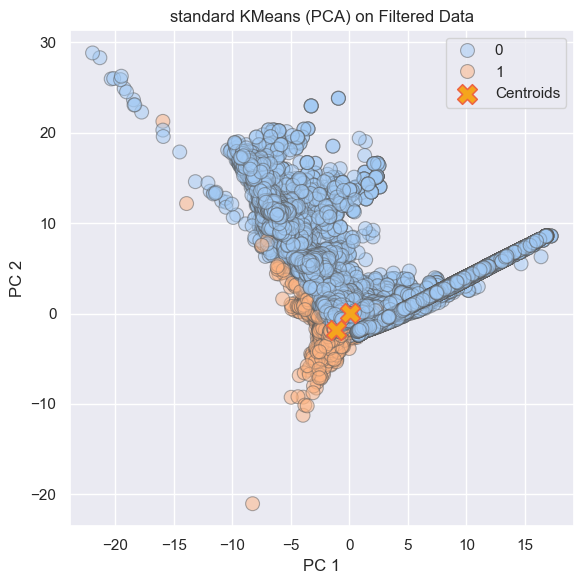

MinMax Scale:

Top 30 Top Mean Difference (Original Scale):
dtcpb: 2144745998.6793
stcpb: 2143587585.4149
Sload: 76176874.1009
Dload: 3685552.9507
Ltime: 340689.3158
Stime: 340689.3082
dbytes: 63260.5874
res_bdy_len: 7130.5136
sbytes: 5969.4778
Sjit: 2126.4036
Djit: 1163.2161
Sintpkt: 543.6375
dmeansz: 392.7130
dwin: 254.9166
swin: 254.0476
Dintpkt: 178.8264
Dpkts: 71.5247
Spkts: 53.0195
smeansz: 37.6321
dloss: 28.4359
dttl: 13.0807
sloss: 8.5485
ct_dst_src_ltm: 7.4786
sttl: 6.6615
ct_srv_dst: 6.2395
ct_srv_src: 5.9063
ct_src_dport_ltm: 5.3527
ct_dst_ltm: 4.6373
ct_src_ltm: 4.3867
ct_dst_sport_ltm: 4.0993

Top 30 Top Median Difference (Original Scale):
dtcpb: 2144442473.5000
stcpb: 2142088705.5000
Stime: 2261191.0000
Ltime: 2261190.5000
Dload: 899396.8125
Sload: 136707.0938
dbytes: 9990.0000
sbytes: 2704.0000
dmeansz: 425.0000
swin: 255.0000
dwin: 255.0000
Sjit: 81.5281
Spkts: 38.0000
Dpkts: 38.0000
Djit: 34.7209
dloss: 11.0000
smeansz: 9.0000
sloss: 7.0000
Sintpkt: 1.4086
Dintpkt: 1.2

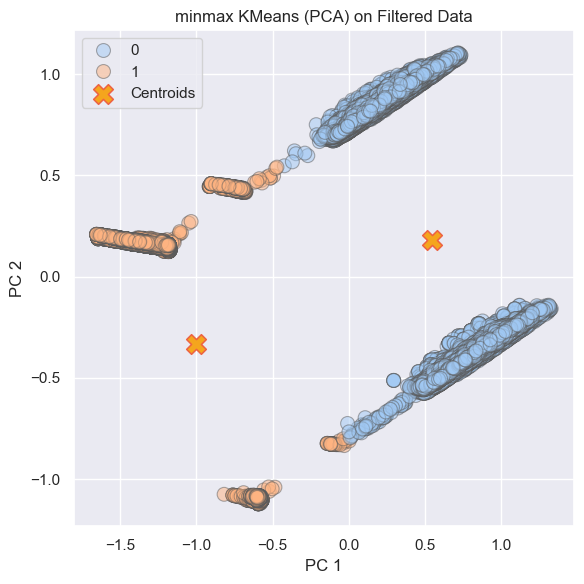

Number of Encoded Features for dsport
3
Number of Encoded Features for proto
3
Number of Encoded Features for sport
3
Number of Encoded Features for srcip
14
Number of Encoded Features for dstip
20


In [104]:
train_data, val_data = get_data(
    size=0.2,
    rs=42,
    threshold=0.1,
    downsample=0.2,
    split_method='shuffle',
    scaler_type='standard',
    check_downsample=True
    )

In [105]:
print(train_data['attack_cat'].value_counts())
print(val_data['attack_cat'].value_counts())

print(train_data['Label'].value_counts())
print(val_data['Label'].value_counts())

attack_cat
Normal            1429817
Generic            172347
Exploits            35587
Fuzzers             19335
DoS                 13099
Reconnaissance      11212
Analysis             2099
Backdoor             1885
Shellcode            1214
Worms                 133
Name: count, dtype: int64
attack_cat
Normal            357311
Generic            43134
Exploits            8938
Fuzzers             4911
DoS                 3254
Reconnaissance      2775
Analysis             578
Backdoor             444
Shellcode            297
Worms                 41
Name: count, dtype: int64
Label
0    1429817
1     256911
Name: count, dtype: int64
Label
0    357311
1     64372
Name: count, dtype: int64


In [106]:
X_train = train_data.drop(columns=['attack_cat', 'Label'])
y_train = train_data['Label']
train_cat = train_data['attack_cat']
X_val = val_data.drop(columns=['attack_cat', 'Label'])
y_val = val_data['Label']
val_cat = val_data['attack_cat']
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_val)
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Precision:", precision_score(y_val, y_pred))
print("Recall:", recall_score(y_val, y_pred))
print("F1 Score:", f1_score(y_val, y_pred))
print("\nClassification Report:\n", classification_report(y_val, y_pred))

Accuracy: 0.9961226798329551
Precision: 0.9869297278837647
Recall: 0.9876809793077735
F1 Score: 0.9873052106869162

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    357311
           1       0.99      0.99      0.99     64372

    accuracy                           1.00    421683
   macro avg       0.99      0.99      0.99    421683
weighted avg       1.00      1.00      1.00    421683



In [107]:
val_data['predicted_label'] = y_pred
val_data['true_label'] = y_val
attack_categories = val_data['attack_cat'].unique()
for category in attack_categories:
    print(f"Evaluation for attack category: {category}")
    category_data = val_data[val_data['attack_cat'] == category]
    if len(category_data) == 0:
        print(f"No samples found for category: {category}")
        print("-" * 50)
        continue
    y_true_category = category_data['true_label']
    y_pred_category = category_data['predicted_label']
    correct_predictions = (y_true_category == y_pred_category).sum()
    total_samples = len(y_true_category)
    accuracy = accuracy_score(y_true_category, y_pred_category)
    precision = precision_score(y_true_category, y_pred_category, zero_division=0)
    recall = recall_score(y_true_category, y_pred_category, zero_division=0)
    f1 = f1_score(y_true_category, y_pred_category, zero_division=0)
    print(f"Total samples: {total_samples}")
    print(f"Correct predictions: {correct_predictions}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")
    print("\nClassification Report:\n", classification_report(y_true_category, y_pred_category, zero_division=0))
    print("-" * 50)

Evaluation for attack category: Normal
Total samples: 357311
Correct predictions: 356469
Accuracy: 0.9976435094357576
Precision: 0.0
Recall: 0.0
F1-Score: 0.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    357311
           1       0.00      0.00      0.00         0

    accuracy                           1.00    357311
   macro avg       0.50      0.50      0.50    357311
weighted avg       1.00      1.00      1.00    357311

--------------------------------------------------
Evaluation for attack category: Generic
Total samples: 43134
Correct predictions: 43131
Accuracy: 0.9999304492975379
Precision: 1.0
Recall: 0.9999304492975379
F1-Score: 0.9999652234394019

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      1.00      1.00     43134

    accuracy                           1.00     43134
   macr

# Downsample by 50% of the Normal labels. - 50% of the Normal labels remain.
- Lower accuracy on some labels.

In [109]:
train_data, val_data = get_data(
    size=0.2,
    rs=42,
    threshold=0.1,
    downsample=0.5,
    split_method='shuffle',
    scaler_type='standard',
    check_downsample=False
    )

C:\Users\adi_s\AppData\Local\Temp\ipykernel_72876\3853468739.py:24: DtypeWarning: Columns (1,3,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'UNSW-NB15_{i}.csv', header=None)
C:\Users\adi_s\AppData\Local\Temp\ipykernel_72876\3853468739.py:24: DtypeWarning: Columns (3,39,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'UNSW-NB15_{i}.csv', header=None)


Dataset 0
Filtered Rows (Cleaning): 62
Downsampled Rows: 335211
Dataset 1
Filtered Rows (Cleaning): 61
Downsampled Rows: 316986
Dataset 2
Filtered Rows (Cleaning): 105
Downsampled Rows: 258546
Dataset 3
Filtered Rows (Cleaning): 75
Downsampled Rows: 167592
Number of Encoded Features for dsport
5
Number of Encoded Features for proto
3
Number of Encoded Features for sport
3
Number of Encoded Features for srcip
14
Number of Encoded Features for dstip
20


In [110]:
print(train_data['attack_cat'].value_counts())

attack_cat
Normal            912178
Generic           172463
Exploits           35388
Fuzzers            19460
DoS                13159
Reconnaissance     11133
Analysis            2134
Backdoor            1879
Shellcode           1192
Worms                141
Name: count, dtype: int64


In [111]:
X_train = train_data.drop(columns=['attack_cat', 'Label'])
y_train = train_data['Label']
train_cat = train_data['attack_cat']
X_val = val_data.drop(columns=['attack_cat', 'Label'])
y_val = val_data['Label']
val_cat = val_data['attack_cat']
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_val)
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Precision:", precision_score(y_val, y_pred))
print("Recall:", recall_score(y_val, y_pred))
print("F1 Score:", f1_score(y_val, y_pred))
print("\nClassification Report:\n", classification_report(y_val, y_pred))

Accuracy: 0.9948577059141513
Precision: 0.9837991837991839
Recall: 0.9929897099511922
F1 Score: 0.9883730824869071

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    227948
           1       0.98      0.99      0.99     64334

    accuracy                           0.99    292282
   macro avg       0.99      0.99      0.99    292282
weighted avg       0.99      0.99      0.99    292282



In [112]:
val_data['predicted_label'] = y_pred
val_data['true_label'] = y_val
attack_categories = val_data['attack_cat'].unique()
for category in attack_categories:
    print(f"Evaluation for attack category: {category}")
    category_data = val_data[val_data['attack_cat'] == category]
    if len(category_data) == 0:
        print(f"No samples found for category: {category}")
        print("-" * 50)
        continue
    y_true_category = category_data['true_label']
    y_pred_category = category_data['predicted_label']
    correct_predictions = (y_true_category == y_pred_category).sum()
    total_samples = len(y_true_category)
    accuracy = accuracy_score(y_true_category, y_pred_category)
    precision = precision_score(y_true_category, y_pred_category, zero_division=0)
    recall = recall_score(y_true_category, y_pred_category, zero_division=0)
    f1 = f1_score(y_true_category, y_pred_category, zero_division=0)
    print(f"Total samples: {total_samples}")
    print(f"Correct predictions: {correct_predictions}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")
    print("\nClassification Report:\n", classification_report(y_true_category, y_pred_category, zero_division=0))
    print("-" * 50)

Evaluation for attack category: Normal
Total samples: 227948
Correct predictions: 226896
Accuracy: 0.9953849123484303
Precision: 0.0
Recall: 0.0
F1-Score: 0.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    227948
           1       0.00      0.00      0.00         0

    accuracy                           1.00    227948
   macro avg       0.50      0.50      0.50    227948
weighted avg       1.00      1.00      1.00    227948

--------------------------------------------------
Evaluation for attack category: DoS
Total samples: 3194
Correct predictions: 3192
Accuracy: 0.9993738259236068
Precision: 1.0
Recall: 0.9993738259236068
F1-Score: 0.9996868149076104

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      1.00      1.00      3194

    accuracy                           1.00      3194
   macro avg 

# Downsample by 90% of the Normal labels. - 10% of the Normal labels remain.
- Fixes accuracy to above 99% for all labels except Normal- this might be a problem too?
- Decreases accuracy slightly in Normal labels.

In [113]:
train_data, val_data = get_data(
    size=0.2,
    rs=42,
    threshold=0.1,
    downsample=0.9,
    split_method='shuffle',
    scaler_type='standard',
    check_downsample=False
    )

C:\Users\adi_s\AppData\Local\Temp\ipykernel_72876\3853468739.py:24: DtypeWarning: Columns (1,3,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'UNSW-NB15_{i}.csv', header=None)
C:\Users\adi_s\AppData\Local\Temp\ipykernel_72876\3853468739.py:24: DtypeWarning: Columns (3,39,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'UNSW-NB15_{i}.csv', header=None)


Dataset 0
Filtered Rows (Cleaning): 62
Downsampled Rows: 603379
Dataset 1
Filtered Rows (Cleaning): 61
Downsampled Rows: 570575
Dataset 2
Filtered Rows (Cleaning): 105
Downsampled Rows: 465383
Dataset 3
Filtered Rows (Cleaning): 75
Downsampled Rows: 301666
Number of Encoded Features for dsport
5
Number of Encoded Features for proto
3
Number of Encoded Features for sport
3
Number of Encoded Features for srcip
17
Number of Encoded Features for dstip
21


In [114]:
val_data['attack_cat'].value_counts()

attack_cat
Normal            55305
Generic           43211
Exploits           9027
Fuzzers            4721
DoS                3330
Reconnaissance     2825
Analysis            546
Backdoor            458
Shellcode           293
Worms                33
Name: count, dtype: int64

In [115]:
X_train = train_data.drop(columns=['attack_cat', 'Label'])
y_train = train_data['Label']
train_cat = train_data['attack_cat']
X_val = val_data.drop(columns=['attack_cat', 'Label'])
y_val = val_data['Label']
val_cat = val_data['attack_cat']
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_val)
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Precision:", precision_score(y_val, y_pred))
print("Recall:", recall_score(y_val, y_pred))
print("F1 Score:", f1_score(y_val, y_pred))
print("\nClassification Report:\n", classification_report(y_val, y_pred))

Accuracy: 0.9928684164377155
Precision: 0.9878628859019211
Recall: 0.9990224070510831
F1 Score: 0.993411307246019

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     55305
           1       0.99      1.00      0.99     64444

    accuracy                           0.99    119749
   macro avg       0.99      0.99      0.99    119749
weighted avg       0.99      0.99      0.99    119749



In [116]:
val_data['predicted_label'] = y_pred
val_data['true_label'] = y_val
attack_categories = val_data['attack_cat'].unique()
for category in attack_categories:
    print(f"Evaluation for attack category: {category}")
    category_data = val_data[val_data['attack_cat'] == category]
    if len(category_data) == 0:
        print(f"No samples found for category: {category}")
        print("-" * 50)
        continue
    y_true_category = category_data['true_label']
    y_pred_category = category_data['predicted_label']
    correct_predictions = (y_true_category == y_pred_category).sum()
    total_samples = len(y_true_category)
    accuracy = accuracy_score(y_true_category, y_pred_category)
    precision = precision_score(y_true_category, y_pred_category, zero_division=0)
    recall = recall_score(y_true_category, y_pred_category, zero_division=0)
    f1 = f1_score(y_true_category, y_pred_category, zero_division=0)
    print(f"Total samples: {total_samples}")
    print(f"Correct predictions: {correct_predictions}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")
    print("\nClassification Report:\n", classification_report(y_true_category, y_pred_category, zero_division=0))
    print("-" * 50)

Evaluation for attack category: Normal
Total samples: 55305
Correct predictions: 54514
Accuracy: 0.9856974957056324
Precision: 0.0
Recall: 0.0
F1-Score: 0.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     55305
           1       0.00      0.00      0.00         0

    accuracy                           0.99     55305
   macro avg       0.50      0.49      0.50     55305
weighted avg       1.00      0.99      0.99     55305

--------------------------------------------------
Evaluation for attack category: Fuzzers
Total samples: 4721
Correct predictions: 4673
Accuracy: 0.989832662571489
Precision: 1.0
Recall: 0.989832662571489
F1-Score: 0.9948903555460933

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.99      0.99      4721

    accuracy                           0.99      4721
   macro avg 

# Get Feature importances using different measures.

In [118]:
features1 = select_features(train_data, 'correlation', 30)
features2 = select_features(train_data, 'ft_importance', 30)
# Not sure why I am getting errors with kbest now.
#features3 = select_features(train_data, 'kbest', 30)

print(features1)
print(features2)
#print(features3)

['sttl', 'ct_state_ttl', 'state_INT', 'ct_dst_src_ltm', 'ct_dst_sport_ltm', 'proto_tcp', 'swin', 'dmeansz', 'dwin', 'state_FIN', 'ct_src_dport_ltm', 'srcip_175.45.176.1', 'ct_srv_dst', 'ct_srv_src', 'srcip_175.45.176.3', 'dstip_149.171.126.18', 'Dload', 'Ltime', 'Stime', 'ct_src_ltm', 'ct_dst_ltm', 'service_dns', 'state_CON', 'dsport_53', 'dtcpb', 'stcpb', 'sport_1043', 'proto_udp', 'srcip_175.45.176.0', 'sport_47439']
['ct_state_ttl', 'sttl', 'Dload', 'state_INT', 'dbytes', 'dttl', 'Dintpkt', 'sbytes', 'Dpkts', 'dmeansz', 'smeansz', 'Sload', 'synack', 'dur', 'tcprtt', 'ackdat', 'Sintpkt', 'ct_dst_sport_ltm', 'Sjit', 'ct_srv_dst', 'ct_src_dport_ltm', 'srcip_149.171.126.18', 'dloss', 'dsport_0', 'dstip_175.45.176.1', 'dstip_175.45.176.3', 'Djit', 'ct_dst_ltm', 'sloss', 'srcip_175.45.176.1']
